# EY Case Study

### Load Data

In [677]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\steve\Desktop\EY\Challenge_Data.csv")
df

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,ClassificationLabel
0,Word1 Word2 Word3 Word4 Word5,44912133,"3,575.00",Word771 Word772,8/31/2018,Word560 Word561 Word366 Word562,Doc1,Category_1
1,Word6 Word7,10719,"1,092.50",Word711 Word773 Word774,8/31/2018,Word563 Word366 Word562,NoDoc,Category_2
2,Word8 Word9 Word10 Word11 Word5,4.80Z+11,75,Word775 Word776,10/31/2018,Word563 Word564 Word9 Word26,NoDoc,Category_1
3,Word12 Word13 Word7,10731,"30,980.00",Word777 Word45 Word160 Word45 Word778,1/1/2018,Word565 Word566,NoDoc,Category_1
4,Word8 Word9 Word10 Word11 Word5,4.80F+11,"3,766.80",Word779 Word258 Word780,1/1/2018,Word567 Word568 Word569 Word570,Doc1,Category_1
...,...,...,...,...,...,...,...,...
5894,Word177 Word178 Word147 Word7,180LSY,"16,880.00",Word2127 Word705 Word825,3/1/2018,Word576 Word366 Word562,Doc3,Category_1
5895,Word16 Word17 Word18 Word7,BL398,"4,200.00",Word785 Word330 Word99 Word26,6/30/2018,Word563 Word564 Word9 Word26,NoDoc,Category_1
5896,Word212 Word213 Word214 Word125 Word119 Word39,74211,170,Word1018 Word190 Word1403,1/1/2018,Word563 Word608 Word609,NoDoc,Category_2
5897,Word148 Word75 Word5,11695,"14,376.00",Word846 Word991,4/1/2018,Word560 Word561 Word315 Word638,Doc1,Category_1


In [678]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5899 entries, 0 to 5898
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Col1                 5899 non-null   object
 1   Col2                 5899 non-null   object
 2   Col3                 5899 non-null   object
 3   Col4                 5746 non-null   object
 4   Col5                 5899 non-null   object
 5   Col6                 5899 non-null   object
 6   Col7                 5899 non-null   object
 7   ClassificationLabel  5899 non-null   object
dtypes: object(8)
memory usage: 368.8+ KB


### Train/test split

I am doing this as early as possible to ensure no data leakage occurs, ensuring evaluation on the test set mimics using the model on completely unseen data as closely as possible.

Following a 90/10 split, as instructed.

In [679]:
train = df.sample(frac=0.9, random_state=1)
test = df.drop(train.index)

## Column-by-column preprocessing

### Classification Label Column

In [680]:
train["ClassificationLabel"].value_counts()

ClassificationLabel
Category_1     4681
Category_2      568
category_1       11
Category4        11
Category_3       11
Categry_6        10
Category 3        9
Category2         4
Category_6        2
Category _3       1
Category 5        1
Name: count, dtype: int64

Note: Category 5 only appears once
* This is too small to meaningfully train on, and it'll also cause errors later during k-fold cross validation
* I need to drop category 5 from the training set

To accommodate this, I'm going to label category 5 as 5 and category 6 as 4, then drop 5 from training
* This is because XGBoost (which I use later) requires multiclass labels to be contiguous, so the rest of the values will be mapped down one (ie, 1 -> 0, 2 -> 1, etc)
* When I cross validate, most folds won't have an entry=4, making it discontiguous and causing errors

In [681]:
def standardize_target(df, test=False):
    '''
    Standardizes target to integers between 0 and 5, inclusive.
    For training data: removes class 5 because it was causing problems in cross validation.
    '''
    df = df.copy()

    df["target"] = df["ClassificationLabel"].str.extract(r'(\d+)').astype(int)
    df["target"] = df["target"] - 1
    df["target"] = df["target"].replace({4: -1, 5: 4})
    df["target"] = df["target"].replace({-1: 5})
    df.drop(columns=["ClassificationLabel"], inplace=True)

    if test:
        return df
    else:
        mask = df["target"] != 5
        df = df[mask]
        return df

df_target_standard = standardize_target(train)

In [682]:
sorted(df_target_standard["target"].unique())

[0, 1, 2, 3, 4]

### Column 2

Column 2 appears to be IDs of some sort

Most likely irrelevant for classification, will just drop for now

Will revisit if model performance is poor           <-- wasn't necessary

In [683]:
def drop_col2(df):
    '''
    Removes column 2 from the df
    '''
    df = df.copy()
    df.drop(columns=["Col2"], inplace=True)
    return df

df_col2_dropped = drop_col2(df_target_standard)

### Column 3

Column 3 appears to be a normal numerical column
* I will convert this to a float dtype

In [684]:
def col3_to_float(df):
    '''
    Converts column 3 from String dtype to float, removing punctuation to accomplish this
    '''
    df = df.copy()
    df["Col3_float"] = (df["Col3"].str.replace(",", "").astype(float))
    df.drop(columns=["Col3"], inplace=True)
    return df

df_col3_float = col3_to_float(df_col2_dropped)

In [685]:
df_col3_float['Col3_float'].describe()

count    5.308000e+03
mean     1.342983e+05
std      9.223991e+05
min     -2.691116e+05
25%      3.600000e+02
50%      1.092500e+03
75%      4.395970e+03
max      8.799524e+06
Name: Col3_float, dtype: float64

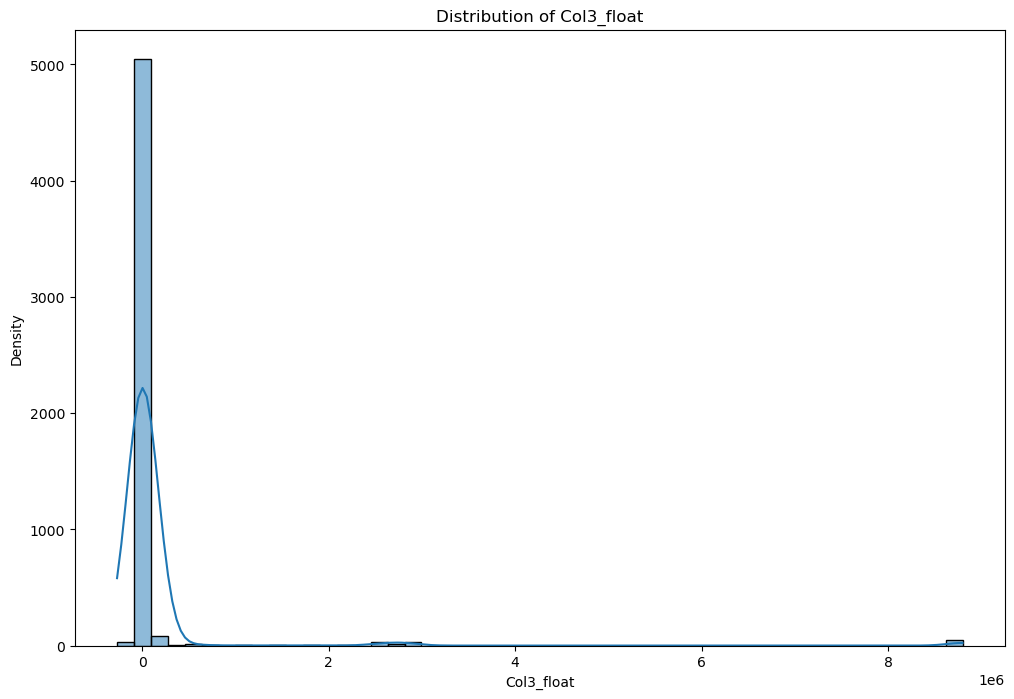

In [686]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(df_col3_float['Col3_float'], bins=50, kde=True)
plt.title('Distribution of Col3_float')
plt.xlabel('Col3_float')
plt.ylabel('Density')
plt.show()

In [687]:
len(df_col3_float[df_col3_float['Col3_float'] < 0])

60

In [688]:
df_col3_float['Col3_float'].skew()

8.442670400560923

Distribution appears very skewed - if using non-tree based models, transformations are necessary.

^I ended up exclusively using tree-based models, so I did not end up using the below transformation functions. I just kept them in the notebook to show my process.

In [689]:
# Use Yeo Johnson transformation to address right skew
#   Use this because it can handle negative values

from sklearn.preprocessing import PowerTransformer

def yeo_johnson(df):
    df = df.copy()

    pt = PowerTransformer(method='yeo-johnson')
    df[["Col3_transformed"]] = pt.fit_transform(df[["Col3_float"]])
    df.drop(columns=["Col3_float"], inplace=True)

    return df

df_col3_transformed = yeo_johnson(df_col3_float)

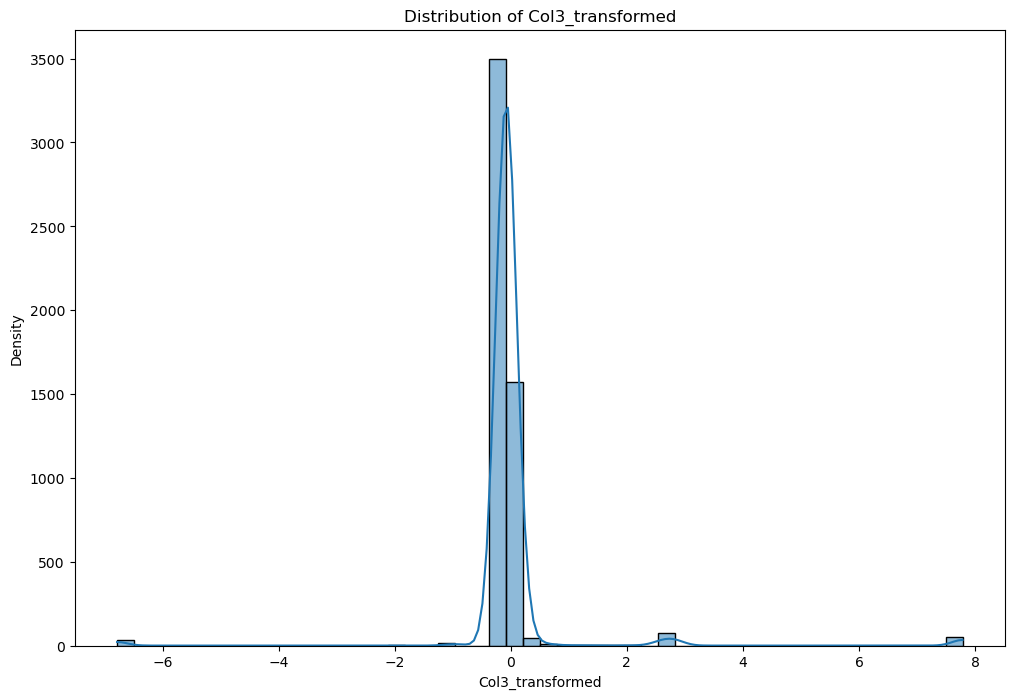

In [690]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(df_col3_transformed['Col3_transformed'], bins=50, kde=True)
plt.title('Distribution of Col3_transformed')
plt.xlabel('Col3_transformed')
plt.ylabel('Density')
plt.show()

In [691]:
df_col3_transformed["Col3_transformed"].skew()

2.9667335657240015

In [692]:
# Apply a symmetric logarithmic transformation to compress the data

def compress(df):
    df = df.copy()

    df["Col3_compressed"] = np.sign(df["Col3_transformed"]) * np.log1p(np.abs(df["Col3_transformed"]))
    df.drop(columns=["Col3_transformed"], inplace=True)

    return df

df_col3_compressed = compress(df_col3_transformed)

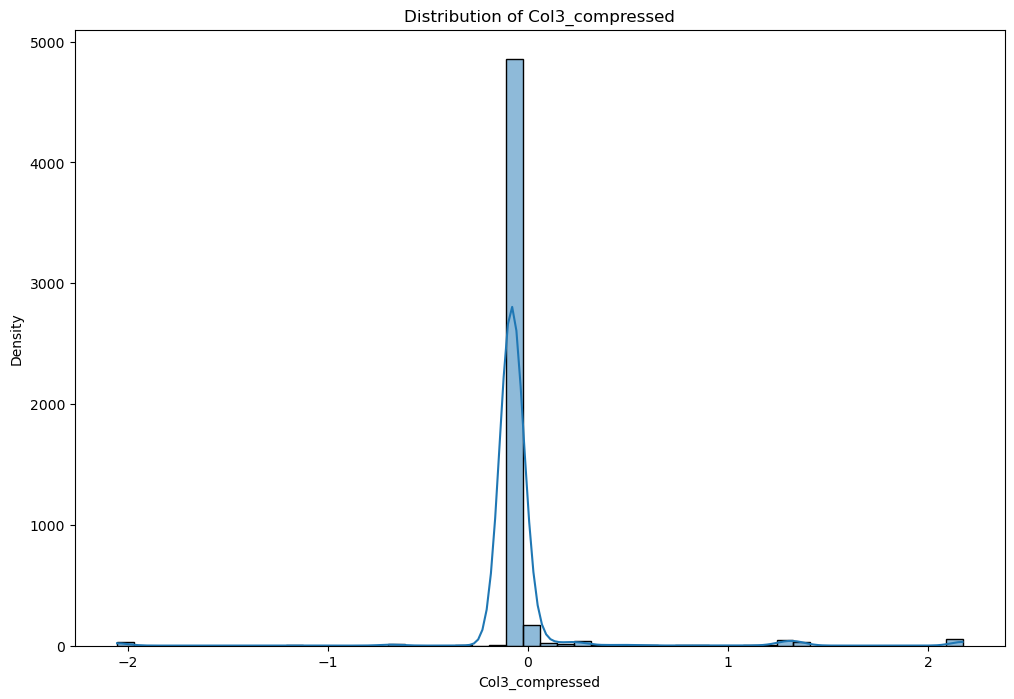

In [693]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(df_col3_compressed['Col3_compressed'], bins=50, kde=True)
plt.title('Distribution of Col3_compressed')
plt.xlabel('Col3_compressed')
plt.ylabel('Density')
plt.show()

In [694]:
df_col3_compressed["Col3_compressed"].skew()

2.7300402619711868

In [695]:
# Use StandardScaling to center and give appropriate range

from sklearn.preprocessing import StandardScaler

def col3_scale(X, test=False, Col3_scaler=None):
    df = X.copy()

    if test:
        df[["Col3_scaled"]] = Col3_scaler.transform(df[["Col3_compressed"]])
        df.drop(columns=["Col3_compressed"], inplace=True)
        return df

    else:
        Col3_scaler = StandardScaler()
        df[["Col3_scaled"]] = Col3_scaler.fit_transform(df[["Col3_compressed"]])
        df.drop(columns=["Col3_compressed"], inplace=True)
        return df, Col3_scaler

df_col3_scaled, Col3_scaler = col3_scale(df_col3_compressed)

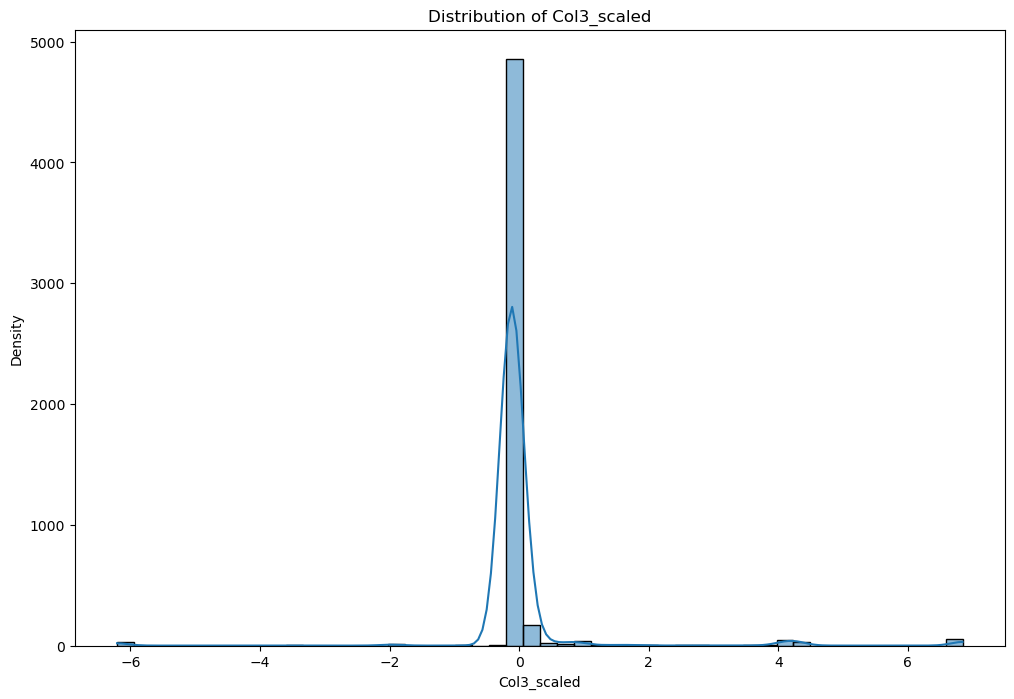

In [696]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.histplot(df_col3_scaled['Col3_scaled'], bins=50, kde=True)
plt.title('Distribution of Col3_scaled')
plt.xlabel('Col3_scaled')
plt.ylabel('Density')
plt.show()

In [697]:
df_col3_scaled['Col3_scaled'].skew()

2.7300402619711863

### Column 5

Convert to datetime format so I can extract more helpful data
* Year, month (0-11), day of month (0-30), day of week (0-6)

Only tracing these raw values is problematic. For example, it would represent January and December as being very far apart when that is not the case
* Sinusoidal encoding preserves cyclical nature of these metrics

In [698]:
def extract_useful_datetime_info(df):
    '''
    Converts column 5 to datetime dtype
    Extracts information of month, year, day of month, day of week from datetime
    When appropriate, sinusoidally encodes this information to preserve cyclical relationships between values
    '''
    df = df.copy()
    df["Col5"] = pd.to_datetime(df["Col5"])

    df["year"] = df["Col5"].dt.year
    df["month"] = df["Col5"].dt.month - 1   
    df["day_of_month"] = df["Col5"].dt.day - 1
    df["day_of_week"] = df["Col5"].dt.dayofweek

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["day_of_week_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_of_week_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    df.drop(columns=["Col5", "day_of_week"], inplace=True)
    return df

df_col5_datetime = extract_useful_datetime_info(df_col3_float)

In [699]:
df_col5_datetime["day_of_month"].unique()

array([ 0, 29, 30])

Dates appear to be always on the first or last of the month

In [700]:
temp = df_col5_datetime[df_col5_datetime["day_of_month"] == 29]
temp["month"].unique()

array([ 8, 10,  5,  3])

Months where it is the 30th day of the month are months with only 30 days

In [701]:
temp = df_col5_datetime[df_col5_datetime["month"] == 1]
temp["day_of_month"].unique()

array([0])

February only has observations on the first of the month, so there aren't any issues there

In [702]:
temp = df_col5_datetime[df_col5_datetime["day_of_month"] == 0]
temp["month"].unique()

array([ 2,  3, 11,  0,  9,  1])

Observations on the first of the month are not exclusive to February

In [703]:
temp = df_col5_datetime[df_col5_datetime["day_of_month"] != 0]
temp["month"].unique()

array([ 8,  7, 10,  4,  9,  5,  6,  3, 11])

Months can have observations on the first day or on the last day - it's not one or the other

Observations are exclusively on the first or last of the month

Because of this, this column should be encoded
* 31st day represents the same thing as 30th day
* The linear difference of 29/30 vs 0 misrepresents the relationship as linear when it's more binary

In [704]:
def encode_day_of_month(df):
    '''
    Converts day of month to binary
    first of month = 1, last of month = 0
    '''
    df = df.copy()

    df["first_of_month"] = (df["day_of_month"] == 0).astype(int)
    df.drop(columns=["day_of_month"], inplace=True)
    return df

df_month_encoded = encode_day_of_month(df_col5_datetime)

In [705]:
df_month_encoded["year"].unique()

array([2018, 2017, 2016])

Only years 2016-2018 in dataset

In [706]:
df_month_encoded["month"].unique()

array([ 2,  3,  8,  7, 10,  4, 11,  9,  0,  5,  6,  1])

All months are in dataset

In [707]:
df_month_encoded["day_of_week_sin"].unique()

array([ 0.43388374, -0.78183148, -0.43388374,  0.97492791,  0.        ,
       -0.97492791,  0.78183148])

All days of week are in dataset

MinMax scale month and year
* Month is consistently between 0 and 11, this will just scale that down to 0 and 1
* Year is between 2016 and 2018, this will scale that down to 0 and 1
* If observation beyond after 2018 is added, will be above 1, but that's ok

NOTE: this step is not necessary for my final models (tree based). However, it doesn't hurt to keep it encoded, so I left it unchanged

In [708]:
from sklearn.preprocessing import MinMaxScaler

def col5_scale(X, test=False, month_scaler=None, year_scaler=None):
    '''
    Scales month and year down to values between 0-1
    '''
    df = X.copy()

    if test:
        df[["month"]] = month_scaler.transform(df[["month"]])
        df[["year"]] = year_scaler.transform(df[["year"]])
        return df

    else:
        month_scaler = MinMaxScaler()
        year_scaler = MinMaxScaler()
        df[["month"]] = month_scaler.fit_transform(df[["month"]])
        df[["year"]] = year_scaler.fit_transform(df[["year"]])
        return df, month_scaler, year_scaler

df_col5_scaled, month_scaler, year_scaler = col5_scale(df_month_encoded)

### Column 7

In [709]:
df_col5_scaled["Col7"].unique()

array(['NoDoc', 'Doc1', 'Doc2', 'Doc3'], dtype=object)

Categorical data like this should be one hot encoded

In [710]:
from sklearn.preprocessing import OneHotEncoder

def encode_col7(df):
    '''
    One hot encodes column 7
    Drops first column that it creates to prevent multicollinearity
    '''
    df = df.copy()

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    encoded = encoder.fit_transform(df[['Col7']])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Col7']), index=df.index)

    df = pd.concat([df, encoded_df], axis=1).drop(columns=['Col7'])
    return df

df_col7_encoded = encode_col7(df_col5_scaled)

### Columns 1, 4, 6

##### Version 1: First word in a sequence recorded in first column, second recorded in second column, ...
* Record the number corresponding to the word, not the word itself

Downsides of this approach:
* Does not represent relationships between words
* Words are represented as quantitative (ie, Word2 is seen as "lower" than Word29)

For these reasons, this preprocessing methodology should only be used for tree based models
* Tree based models account for relationships between variables better than linear models
* Tree based are nonlinear, which can limit the harm of the quantitative representation of the words

In [711]:
def word_nums_to_cols(df, cols=["Col1", "Col4", "Col6"]):
    '''
    Finds the maximum amount of words in each of columns 1, 4, 6
    Creates that many new columns, whose values are the numbers corresponding to the word in that position
    If there is no word in a certain position, that value is null
    Null values are filled with zeroes because not all of my models can natively handle nulls
    '''
    df = df.copy()

    for col in cols:
        to_list = df[col].str.split()
        max_words = to_list.dropna().str.len().max()

        to_ints = to_list.apply(lambda words: [int(word[4:]) for word in words] if isinstance(words, list) else [np.nan]*int(max_words))
        to_cols = pd.DataFrame(to_ints.tolist(), columns=[f'{col}_{i+1}' for i in range(max_words)], index=df.index)

        df = pd.concat([df, to_cols], axis=1)
        df = df.fillna(0)
    
    df.drop(columns=cols, inplace=True)
    return df

df_col146_v1 = word_nums_to_cols(df_col7_encoded)

##### Version 2: binary occurrence
* Have a column for each word, set it to 0 by default, increment by 1 every time it appears in a column

Could be problematic because:
* Results in 2000+ columns
* Does not account for position of words
* Does not represent relationships between words

For these reasons, linear models are prioritized because they are more efficient with many columns.
* Logistic regression variations will likely perform best
* L1/PCA will be used to massively reduce number of features

In [712]:
from sklearn.feature_extraction.text import CountVectorizer

def word_nums_to_bin_occ(df, cols=["Col1", "Col4", "Col6"]):
    '''
    Each word is represented with a column
    Values in these columns are set to 0 by default
    Every time each word shows up in a row, the value in the corresponding column is incremented by 1
    '''
    df = df.copy()

    vectorizers = {}
    binary_dfs = []

    for col in cols:
        word_series = df[col].fillna("")
        vector = CountVectorizer(binary=True)
        occ = vector.fit_transform(word_series)

        bin_df = pd.DataFrame(
            occ.toarray(),
            columns=[f"{col}_{token}" for token in vector.get_feature_names_out()],
            index=df.index
        )

        vectorizers[col] = vector
        binary_dfs.append(bin_df)

    df = pd.concat([df] + binary_dfs, axis=1)
    df.drop(columns=cols, inplace=True)
    return df

df_col146_v2 = word_nums_to_bin_occ(df_col7_encoded)

#### I am now done with primary data cleaning and feature engineering.

I later decided to use version 1 for columns 1, 4, and 6, so I'm setting the output of that as my fully cleaned df.

In [713]:
df_cleaned = df_col146_v1

## Feature Selection

Feature Importance: Correlation Heatmap
* Represents linear relationships

In [714]:
# Need to split into multiple smaller dataframes in order for the visualization to be interpretable

corr_df1 = df_cleaned.iloc[:, 0:12]
corr_df2 = df_cleaned.iloc[:, [0] + list(range(12, 25))]
corr_df3 = df_cleaned.iloc[:, [0] + list(range(25, 38))]

def corr_heatmap(df):
    '''
    Makes a correlation heatmap
    '''
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .8}
    )

    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()


Heatmap of features from all columns except 1, 4, and 6

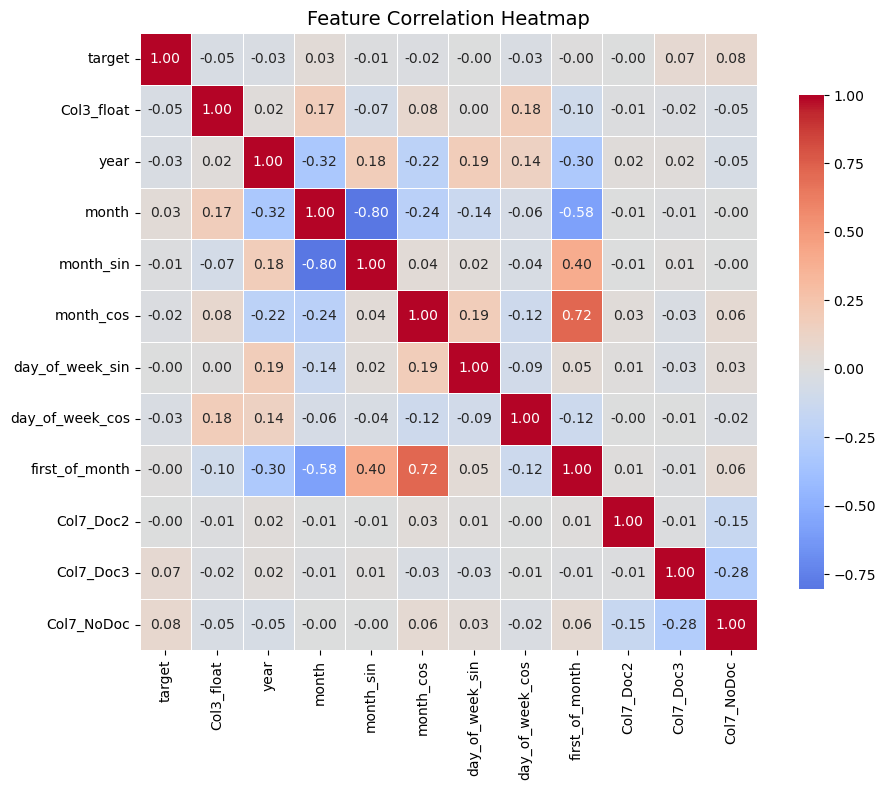

In [715]:
corr_heatmap(corr_df1)

The next two heatmaps are correlations of features from columns 1, 4, and 6, as well as the target column.

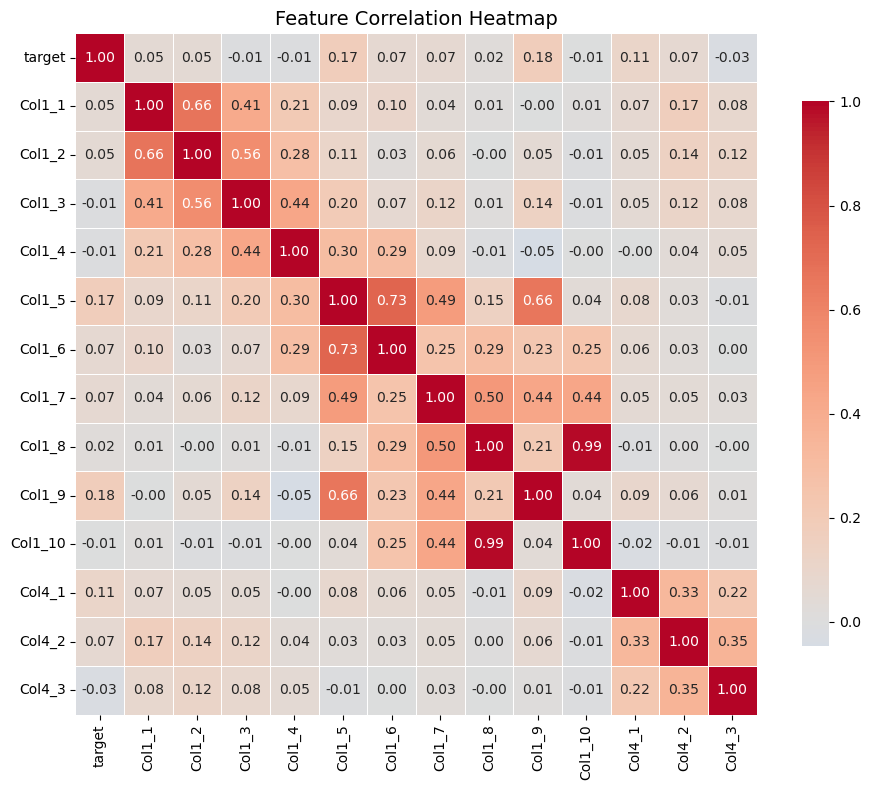

In [716]:
corr_heatmap(corr_df2)

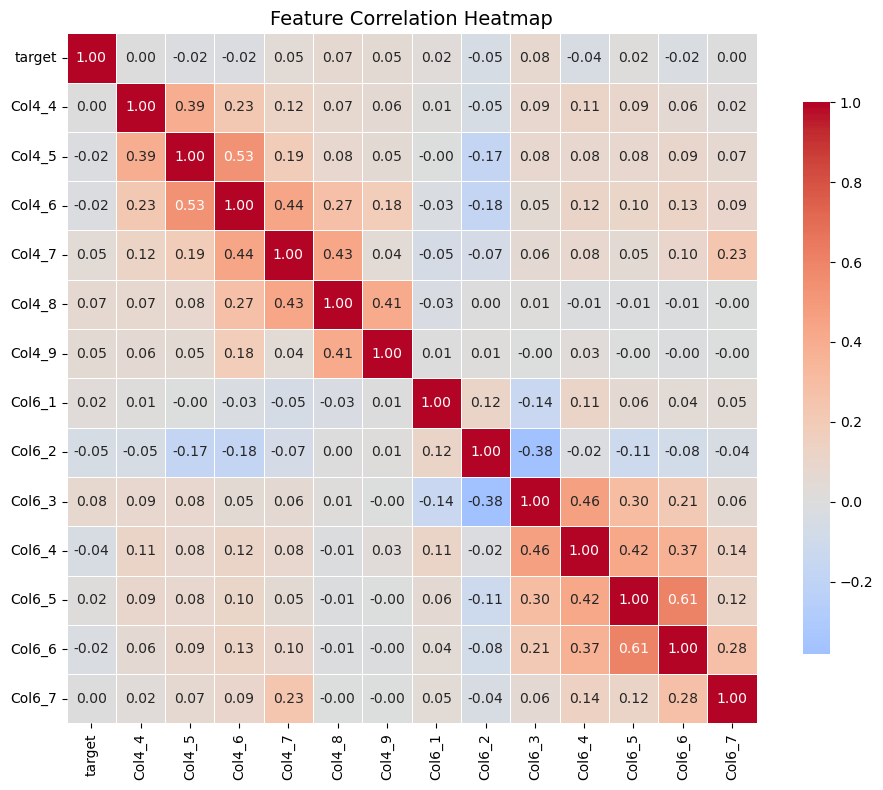

In [717]:
corr_heatmap(corr_df3)

##### At this point, I am concluding that a tree based model is most appropriate for this task. This is because:

1. Linear correlations between explanatory variables and the target variable are mostly very weak, indicating a nonlinear model would perform better.

2. A neural network would be overkill in this scenario - tedious to train/finetune and complexity would likely lead to overfitting

3. The correlations with the target variable that are not weak are those from columns 1, 4, and 6 using Version 1 to preprocess. Version 1 also just generally has less downsides than Version 2. As discussed earlier, Version 1 favors tree based models due to their ability to better account for relationships between variables and because their nonlinear nature can limit the harm of a quantitative representation of words

4. Even after transformations, column 3 had a distribution quite un-Gaussian - bad for linear models, no effect for tree based models.

5. Generally speaking, tree based models (specifically, gradient boosting) tend to have the best performance on tabular data.

## Feature Selection, cont.

### Permutation Importance
The random forest I am creating here is not one of my final models - it's just to see how much each feature is impacting model performance so I can choose which ones to get rid of

In [718]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def perm_importance(df):
    '''
    Find the importance of each feature within a random forest
    '''
    df = df.copy()

    train = df.sample(frac=0.9, random_state=1)
    val = df.drop(train.index)

    X_train = train.drop(columns=["target"])
    y_train = train["target"]
    X_val = val.drop(columns=["target"])
    y_val = val["target"]

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        n_jobs=-1,
        random_state=1
    )

    rf.fit(X_train, y_train)

    result = permutation_importance(rf, X_val, y_val)

    importances = result.importances_mean
    imp_df = pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=True)
    
    return imp_df

imp_df = perm_importance(df_cleaned)
imp_df

,feature,importance
2,month,-0.002260
3,month_sin,-0.001883
30,Col6_1,-0.001507
23,Col4_3,-0.001130
6,day_of_week_cos,-0.000753
10,Col7_NoDoc,-0.000753
20,Col1_10,0.000000
35,Col6_6,0.000000
28,Col4_8,0.000000
29,Col4_9,0.000000


In [719]:
def perm_select(df, imp_df):
    '''
    Keep all features with an importance score >= 0.001
    '''
    df = df.copy()
    imp_df = imp_df.copy()

    cutoff = 0.001
    to_keep = set(imp_df.loc[imp_df["importance"] >= cutoff, "feature"])
    to_keep.add("target")
    not_kept = [col for col in df.columns if col not in to_keep and col != "target"]

    return df[list(to_keep)], not_kept


df_selected, not_selected = perm_select(df_cleaned, imp_df)
not_selected

['year',
 'month',
 'month_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'first_of_month',
 'Col7_Doc2',
 'Col7_Doc3',
 'Col7_NoDoc',
 'Col1_10',
 'Col4_3',
 'Col4_4',
 'Col4_8',
 'Col4_9',
 'Col6_1',
 'Col6_5',
 'Col6_6',
 'Col6_7']

### VIF Score Analysis

Finding features with VIF (Variance Inflation Factor) scores greater than 5 to remove. This score indicates a high level of correlation with other features (multicollinearity), which can hurt model performance.

In [720]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def vif(df):
    '''
    Computes Variance Inflation Factor of each explanatory variable
    Returns them in descending order
    '''
    df = df.copy()

    train_vif = df.astype(float)
    train_vif = sm.add_constant(train_vif)
    train_vif = train_vif.fillna(0)

    vif_df = pd.DataFrame()
    vif_df["feature"] = train_vif.columns
    vif_df["VIF"] = [variance_inflation_factor(train_vif.values, i) for i in range(train_vif.shape[1])]
    vif_df = vif_df[vif_df["feature"] != "const"].reset_index(drop=True)
    vif_df = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)

    return vif_df

print(vif(df_selected))

       feature       VIF
0       Col1_5  7.381239
1       Col1_6  3.905410
2       Col1_9  3.061551
3       Col1_2  2.290275
4       Col1_7  2.048370
5       Col1_1  1.966080
6       Col1_8  1.851216
7       Col1_3  1.800290
8       Col6_3  1.758541
9       Col4_6  1.742938
10      Col1_4  1.569705
11      Col6_4  1.474114
12      Col4_5  1.443803
13      Col6_2  1.337468
14      Col4_7  1.272098
15      Col4_2  1.217390
16      Col4_1  1.147846
17      target  1.088398
18   month_cos  1.069624
19  Col3_float  1.033071


Testing to see how VIF changes after dropping the most problematic column

In [721]:
temp = df_selected.drop(columns=["Col1_5"])
print(vif(temp))

       feature       VIF
0       Col1_2  2.285587
1       Col1_1  1.966021
2       Col1_3  1.796465
3       Col6_3  1.750423
4       Col4_6  1.740619
5       Col1_7  1.620937
6       Col1_9  1.488786
7       Col1_4  1.475242
8       Col6_4  1.474035
9       Col4_5  1.442852
10      Col1_8  1.425957
11      Col6_2  1.334595
12      Col1_6  1.318032
13      Col4_7  1.272082
14      Col4_2  1.214023
15      Col4_1  1.147797
16      target  1.071635
17   month_cos  1.068669
18  Col3_float  1.032756


VIF scores look good, multicollinearity should be addressed

##### Feature Selection Function

In [722]:
def feature_selection(df):
    '''
    Drops the columns with the highest VIFs
    '''
    df = df.copy()

    df.drop(columns=[
        'Col1_5',
        'year',
        'month',
        'month_sin',
        'month_cos',
        'day_of_week_sin',
        'day_of_week_cos',
        'first_of_month',
        'Col7_Doc2',
        'Col7_Doc3',
        'Col7_NoDoc',
        'Col1_10',
        'Col4_3',
        'Col4_4',
        'Col4_8',
        'Col4_9',
        'Col6_1',
        'Col6_5',
        'Col6_6',
        'Col6_7'], errors='ignore', inplace=True)

    return df

train_final = feature_selection(df_cleaned)

## Preprocessing Pipeline

In [723]:
def preprocess(df, test=False, month_scaler=None, year_scaler=None, version=1):
    '''
    Combines data cleaning, feature engineering, and feature selection steps into a single, scalable pipeline
    '''
    df = df.copy()

    df = standardize_target(df, test)
    df = drop_col2(df)

    df = col3_to_float(df)
    # df = yeo_johnson(df)                              <-- Commenting these out because
    # df = compress(df)                                 <-- these transformations would
    # if test:                                          <-- only be helpful for a non-
        # df = col3_scale(df, True, col3_scaler)        <-- tree-based model, and I later
    # else:                                             <-- decided I would be exclusively 
        # df, col3_scaler = col3_scale(df)              <-- using tree based models
    
    df = extract_useful_datetime_info(df)
    df = encode_day_of_month(df)
    if test:
        df = col5_scale(df, True, month_scaler, year_scaler)
    else:
        df, month_scaler, year_scaler = col5_scale(df)

    df = encode_col7(df)

    if version == 1:
        df = word_nums_to_cols(df)
    elif version == 2:
        df = word_nums_to_bin_occ(df)

    df = feature_selection(df)

    X = df.drop(columns=["target"])
    y = df["target"]

    if test:
        return X, y
    else:
        mask = y != 5
        X = X[mask]
        y = y[mask]
        return X, y, month_scaler, year_scaler

X_train, y_train, month_scaler, year_scaler = preprocess(train)
X_test, y_test = preprocess(test, True, month_scaler, year_scaler)

Verify pipeline works as intended

In [724]:
X_train_manual = train_final.drop(columns=["target"])

X_train.equals(X_train_manual)

True

Ensure X_train and X_test have the same columns

In [725]:
def align_train_test(X_train, X_test):
    '''
    Ensures consistency in columns between train and test
    Removes any explanatory columns not in both
    '''
    X_train = X_train.copy()
    X_test = X_test.copy()

    common_cols = X_train.columns.intersection(X_test.columns)

    X_train = X_train[common_cols]
    X_test = X_test[common_cols]

    return X_train, X_test

X_train, X_test = align_train_test(X_train, X_test)

## Model Development

### Baseline Model

Will always predicts majority class (1)
* Used as a baseline to improve upon
* Goal is to maximize accuracy, but because the dataset is so imbalanced, I want to look at both normal accuracy and balanced accuracy (average accuracy per class, regardless of number of observations)

In [726]:
y_train.value_counts()

target
0    4692
1     572
2      21
4      12
3      11
Name: count, dtype: int64

In [727]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

n = len(y_test)
y_pred_baseline = [0] * n

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Accuracy: {baseline_accuracy}")
print(f"Baseline Balanced Accuracy: {baseline_balanced_accuracy}")

Baseline Accuracy: 0.8864406779661017
Baseline Balanced Accuracy: 0.2


### Contender 1: Random Forest

For each of these models, I use k-fold cross validation (k=5) alongside random grid search to finetune hyperparameters before applying optimal models to the test set.

Minimal exposure to test set is ideal to ensure it mimics true unseen data.

In [728]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

rf = RandomForestClassifier(random_state=1)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'accuracy': make_scorer(accuracy_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    scoring=scoring,
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

random_search_rf.fit(X_train, y_train)

best_index = random_search_rf.best_index_
best_model_accuracy = random_search_rf.cv_results_['mean_test_accuracy'][best_index]

print("Best Hyperparameters:", random_search_rf.best_params_)
print("Best Balanced Accuracy:", random_search_rf.best_score_)
print("Best Accuracy:", best_model_accuracy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Balanced Accuracy: 0.6926355470978471
Best Accuracy: 0.9606266340782866


### Contender 2: XGBoost

In [729]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state=1,
    objective='multi:softmax',
    num_class=len(set(y_train)),
    use_label_encoder=False,
    eval_metric='mlogloss'
)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0, 0.5, 1, 2, 5, 10],
    'reg_alpha': [0, 0.1, 0.5, 1, 2],
    'max_delta_step': [0, 1, 5] 
}

scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'accuracy': make_scorer(accuracy_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    scoring=scoring,
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

random_search_xgb.fit(X_train, y_train)

best_index = random_search_xgb.best_index_
best_model_accuracy = random_search_xgb.cv_results_['mean_test_accuracy'][best_index]

print("Best Hyperparameters:", random_search_xgb.best_params_)
print("Best Balanced Accuracy:", random_search_xgb.best_score_)
print("Best Accuracy:", best_model_accuracy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\steve\New folder\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Best Balanced Accuracy: 0.7274998812242296
Best Accuracy: 0.9619441915117564


### Contender 3: LightGBM

In [730]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    random_state=1,
    objective='multiclass',
    num_class=len(set(y_train)),
    verbose=-1
)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 10, 15], 
    'num_leaves': [15, 31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [5, 10, 20, 30],
    'reg_lambda': [0, 0.1, 1, 5],
    'reg_alpha': [0, 0.1, 1, 5]
}

scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'accuracy': make_scorer(accuracy_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    scoring=scoring,
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=1
)

random_search_lgbm.fit(X_train, y_train)

best_index = random_search_lgbm.best_index_
best_model_accuracy = random_search_lgbm.cv_results_['mean_test_accuracy'][best_index]

print("Best Hyperparameters:", random_search_lgbm.best_params_)
print("Best Balanced Accuracy:", random_search_lgbm.best_score_)
print("Best Accuracy:", best_model_accuracy)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 15, 'n_estimators': 200, 'min_child_samples': 30, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best Balanced Accuracy: 0.7374955908096793
Best Accuracy: 0.9632642338979501


#### Best performing model so far: LightGBM

In [731]:
rf_model = random_search_rf.best_estimator_
xgb_model = random_search_xgb.best_estimator_
lgbm_model = random_search_lgbm.best_estimator_

#### Now: try each on test set

### Random Forest

In [732]:
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, log_loss)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_bal_acc = balanced_accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='macro')
rf_rec = recall_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_roc = roc_auc_score(y_test, y_proba_rf, multi_class='ovr', average='macro')
rf_ll = log_loss(y_test, y_proba_rf)

print("Random Forest Test Set Results")
print(f"Accuracy:           {rf_acc}")
print(f"Balanced Accuracy:  {rf_bal_acc}")
print(f"Precision:          {rf_prec}")
print(f"Recall:             {rf_rec}")
print(f"F1-score:           {rf_f1}")
print(f"ROC AUC:            {rf_roc}")
print(f"Log Loss:           {rf_ll}")

Random Forest Test Set Results
Accuracy:           0.9593220338983051
Balanced Accuracy:  0.7064756781281394
Precision:          0.6057494184114324
Recall:             0.5887297317734496
F1-score:           0.5965211891208096
ROC AUC:            0.8870813719873404
Log Loss:           0.16744731988426334


c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

In [733]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)

xgb_acc = accuracy_score(y_test, y_pred)
xgb_bal_acc = balanced_accuracy_score(y_test, y_pred)
xgb_prec = precision_score(y_test, y_pred, average='macro')
xgb_rec = recall_score(y_test, y_pred, average='macro')
xgb_f1 = f1_score(y_test, y_pred, average='macro')
xgb_roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
xgb_ll = log_loss(y_test, y_proba)

print("XGBoost Test Set Results")
print(f"Accuracy:           {xgb_acc}")
print(f"Balanced Accuracy:  {xgb_bal_acc}")
print(f"Precision:          {xgb_prec}")
print(f"Recall:             {xgb_rec}")
print(f"F1-score:           {xgb_f1}")
print(f"ROC AUC:            {xgb_roc}")
print(f"Log Loss:           {xgb_ll}")

XGBoost Test Set Results
Accuracy:           0.9576271186440678
Balanced Accuracy:  0.6358803512979226
Precision:          0.5546717171717171
Recall:             0.5299002927482689
F1-score:           0.5411869879795165
ROC AUC:            0.9715378083074745
Log Loss:           0.11597268557466676


c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LightGBM

In [734]:
y_pred = lgbm_model.predict(X_test)
y_proba = lgbm_model.predict_proba(X_test)

lgbm_acc = accuracy_score(y_test, y_pred)
lgbm_bal_acc = balanced_accuracy_score(y_test, y_pred)
lgbm_prec = precision_score(y_test, y_pred, average='macro')
lgbm_rec = recall_score(y_test, y_pred, average='macro')
lgbm_f1 = f1_score(y_test, y_pred, average='macro')
lgbm_roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
lgbm_ll = log_loss(y_test, y_proba)

print("LightGBM Test Set Results")
print(f"Accuracy:           {lgbm_acc}")
print(f"Balanced Accuracy:  {lgbm_bal_acc}")
print(f"Precision:          {lgbm_prec}")
print(f"Recall:             {lgbm_rec}")
print(f"F1-score:           {lgbm_f1}")
print(f"ROC AUC:            {lgbm_roc}")
print(f"Log Loss:           {lgbm_ll}")

LightGBM Test Set Results
Accuracy:           0.9576271186440678
Balanced Accuracy:  0.6754979421201024
Precision:          0.5937867082316798
Recall:             0.562914951766752
F1-score:           0.5768668046928916
ROC AUC:            0.9850021790154045
Log Loss:           0.16225984384419298


c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\steve\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Best Performing Model: Random Forest

My guess is that boosting overfit slightly, leading to the random forest being the best performer. There being a relatively small number of columns in X makes this a likely explanation

In [735]:
accuracy_improvement = ((rf_acc - baseline_accuracy) / abs(baseline_accuracy)) * 100
balanced_accuracy_improvement = ((rf_bal_acc - baseline_balanced_accuracy) / abs(baseline_balanced_accuracy)) * 100

print(accuracy_improvement)
print(balanced_accuracy_improvement)

8.22179732313575
253.2378390640697


## Final Accuracy: 0.96 (+8.2% from baseline)

## Final Balanced Accuracy: 0.71 (+253.2% from baseline)

### Evolution of Model Performance: Visualization

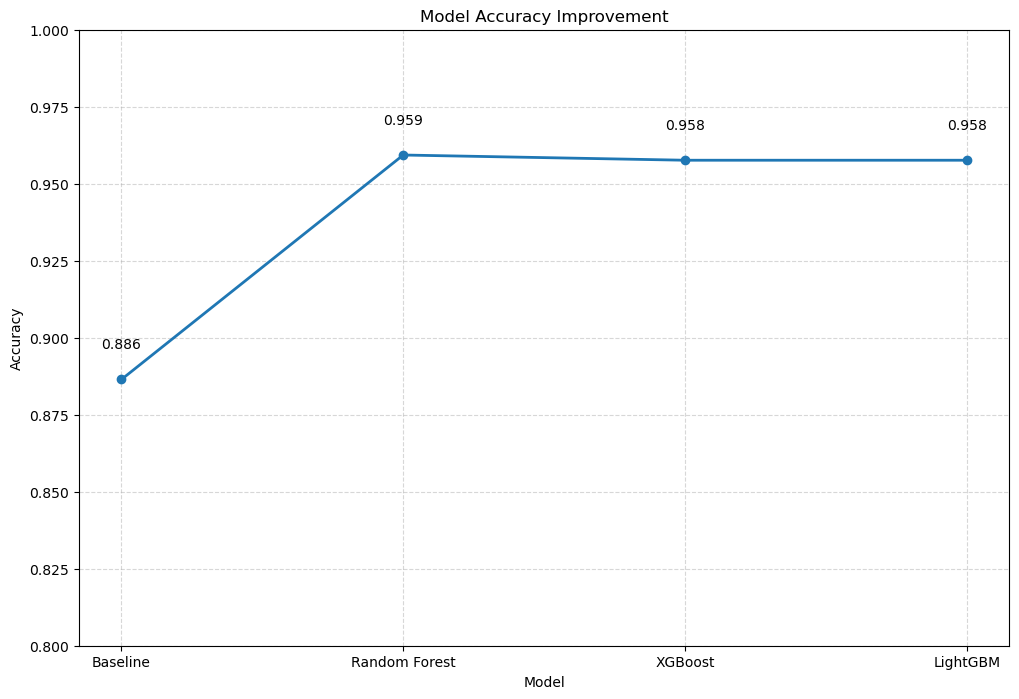

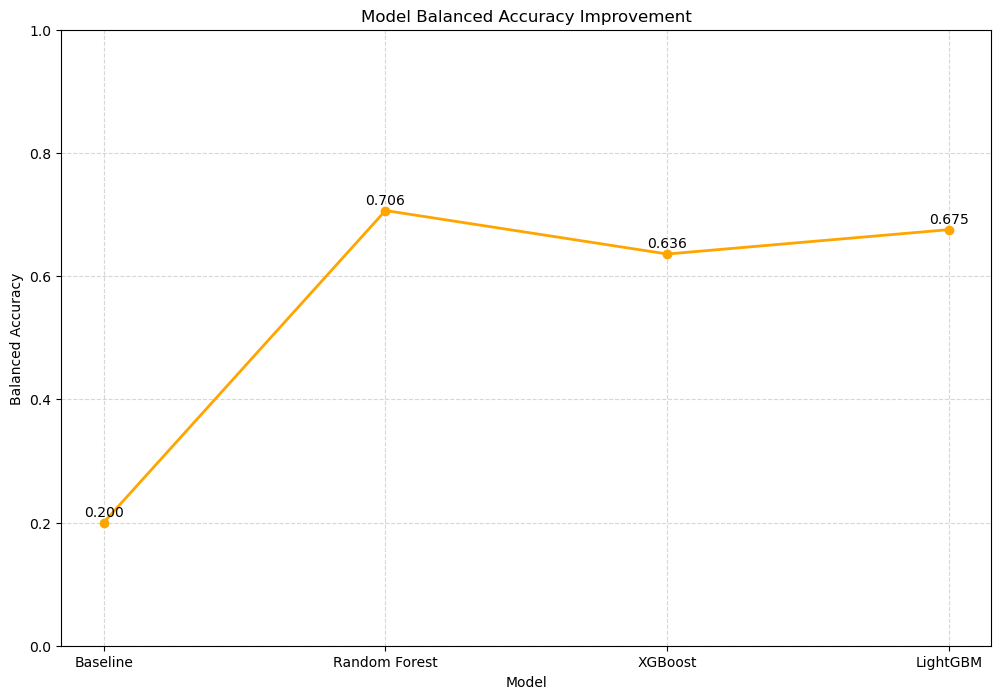

In [736]:
models = ["Baseline", "Random Forest", "XGBoost", "LightGBM"]
accuracies = [baseline_accuracy, rf_acc, xgb_acc, lgbm_acc]
balanced_accuracies = [baseline_balanced_accuracy, rf_bal_acc, xgb_bal_acc, lgbm_bal_acc]

df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracies,
    "Balanced Accuracy": balanced_accuracies
})

plt.figure(figsize=(12, 8))
plt.plot(df["Model"], df["Accuracy"], marker="o", linestyle="-", linewidth=2)
plt.title("Model Accuracy Improvement")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1)
for i, val in enumerate(df["Accuracy"]):
    plt.text(i, val + 0.01, f"{val:.3f}", ha="center")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(df["Model"], df["Balanced Accuracy"], marker="o", color="orange", linestyle="-", linewidth=2)
plt.title("Model Balanced Accuracy Improvement")
plt.xlabel("Model")
plt.ylabel("Balanced Accuracy")
plt.ylim(0, 1)
for i, val in enumerate(df["Balanced Accuracy"]):
    plt.text(i, val + 0.01, f"{val:.3f}", ha="center")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Accuracy by Class

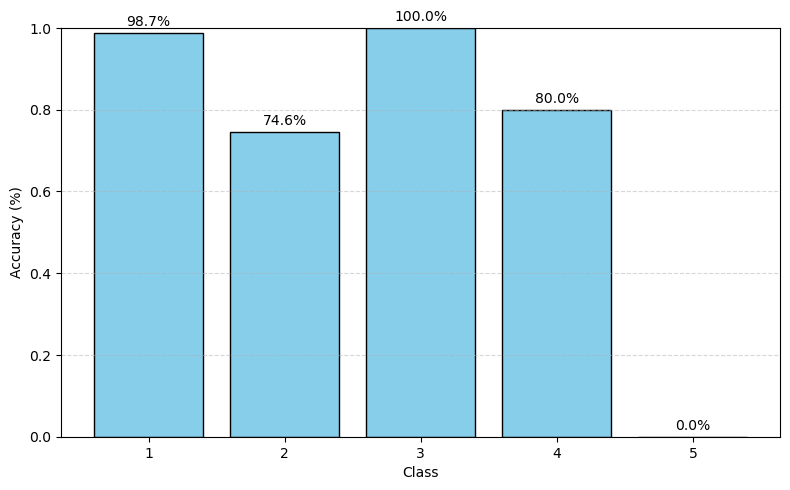

In [737]:
classes = np.unique(y_test)
class_accuracies = []

for cls in classes:
    idx = (y_test == cls)
    acc = np.mean(y_pred_rf[idx] == y_test[idx])
    class_accuracies.append(acc)
adjusted_classes = [cls + 1 if cls != 5 else 5 for cls in classes]

acc_df = pd.DataFrame({
    "Class": adjusted_classes,
    "Accuracy": class_accuracies
}).sort_values("Class")

plt.figure(figsize=(8, 5))
bars = plt.bar(acc_df["Class"].astype(str), acc_df["Accuracy"], color="skyblue", edgecolor="black")
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height*100:.1f}%", ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Count of each class in y_test

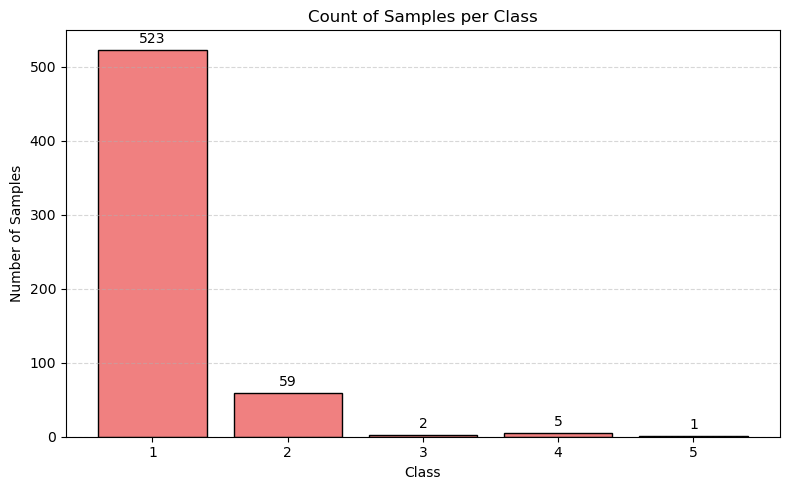

In [738]:
classes, counts = np.unique(y_test, return_counts=True)
adjusted_classes = [cls + 1 if cls != 5 else 5 for cls in classes]

count_df = pd.DataFrame({
    "Class": adjusted_classes,
    "Count": counts
}).sort_values("Class")

plt.figure(figsize=(8, 5))
bars = plt.bar(count_df["Class"].astype(str), count_df["Count"], color="lightcoral", edgecolor="black")
plt.title("Count of Samples per Class")
plt.xlabel("Class")
plt.ylabel("Number of Samples")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(count_df["Count"]) * 0.01,
             f"{int(height)}", ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


This helps explain why our balanced accuracy was lower than our normal accuracy. Class 5 is treated as equal to the rest, even though there was only one observation in it. So, one wrong prediction results in a 20% decrease in balanced accuracy. Classes 3 and 4 have similar distortion effects - balanced accuracy is informative, but requires context.